In [175]:
import pyedflib
import os
import numpy as np
from tqdm import tqdm

# Root path del dataset
dataset_root = "./CHB-MIT/"
processed_root = os.path.join(dataset_root, "processed_numpy")
os.makedirs(processed_root, exist_ok=True)

# Parametri noti
segment_duration = 10  # secondi
sampling_rate = 256  # fissa a 256 Hz (CHB-MIT)
segment_length = segment_duration * sampling_rate

# Liste per unione globale
all_segments = []
all_sources = []  # per tracciare da dove viene ogni segmento

# Scorri tutte le cartelle dei pazienti
for patient_folder in sorted(os.listdir(dataset_root)):
    patient_path = os.path.join(dataset_root, patient_folder)
    if not os.path.isdir(patient_path) or not patient_folder.startswith("chb"):
        continue

    print(f"\nProcessing paziente: {patient_folder}")
    
    # Scorri tutti i file EDF del paziente
    for file_name in sorted(os.listdir(patient_path)):
        if not file_name.endswith(".edf"):
            continue

        file_path = os.path.join(patient_path, file_name)

        try:
            with pyedflib.EdfReader(file_path) as edf_file:
                n_channels = edf_file.signals_in_file
                total_samples = edf_file.getNSamples()[0]
                n_segments = total_samples // segment_length

                # Scegli i 18 canali da usare
                selected_channels = list(range(18))  # oppure escludi canali specifici

                # Leggi solo i canali selezionati
                signals = np.array([edf_file.readSignal(ch) for ch in selected_channels])

                for idx in range(n_segments):
                    start = idx * segment_length
                    end = start + segment_length
                    segment = signals[:, start:end]
                    if segment.shape[1] == segment_length:
                        all_segments.append(segment)
                        all_sources.append({
                            "patient": patient_folder,
                            "file": file_name,
                            "segment_index": idx
                        })

        except Exception as e:
            print(f"Errore con {file_name}: {e}")

# Converti in array numpy
all_segments_array = np.array(all_segments)  # shape: (N, channels, 2560)
print(f"\nTotale segmenti: {all_segments_array.shape[0]}")

# Salva
np.save(os.path.join(processed_root, "all_segments.npy"), all_segments_array)

# Salva le info di origine per riferimento
import json
with open(os.path.join(processed_root, "all_sources.json"), "w") as f:
    json.dump(all_sources, f, indent=2)

print("Segmenti salvati con successo.")


Processing paziente: chb01

Processing paziente: chb02

Processing paziente: chb03

Totale segmenti: 4055
Segmenti salvati con successo.


In [176]:
all_segments_array.shape

(4055, 18, 2560)

# Preprocessing

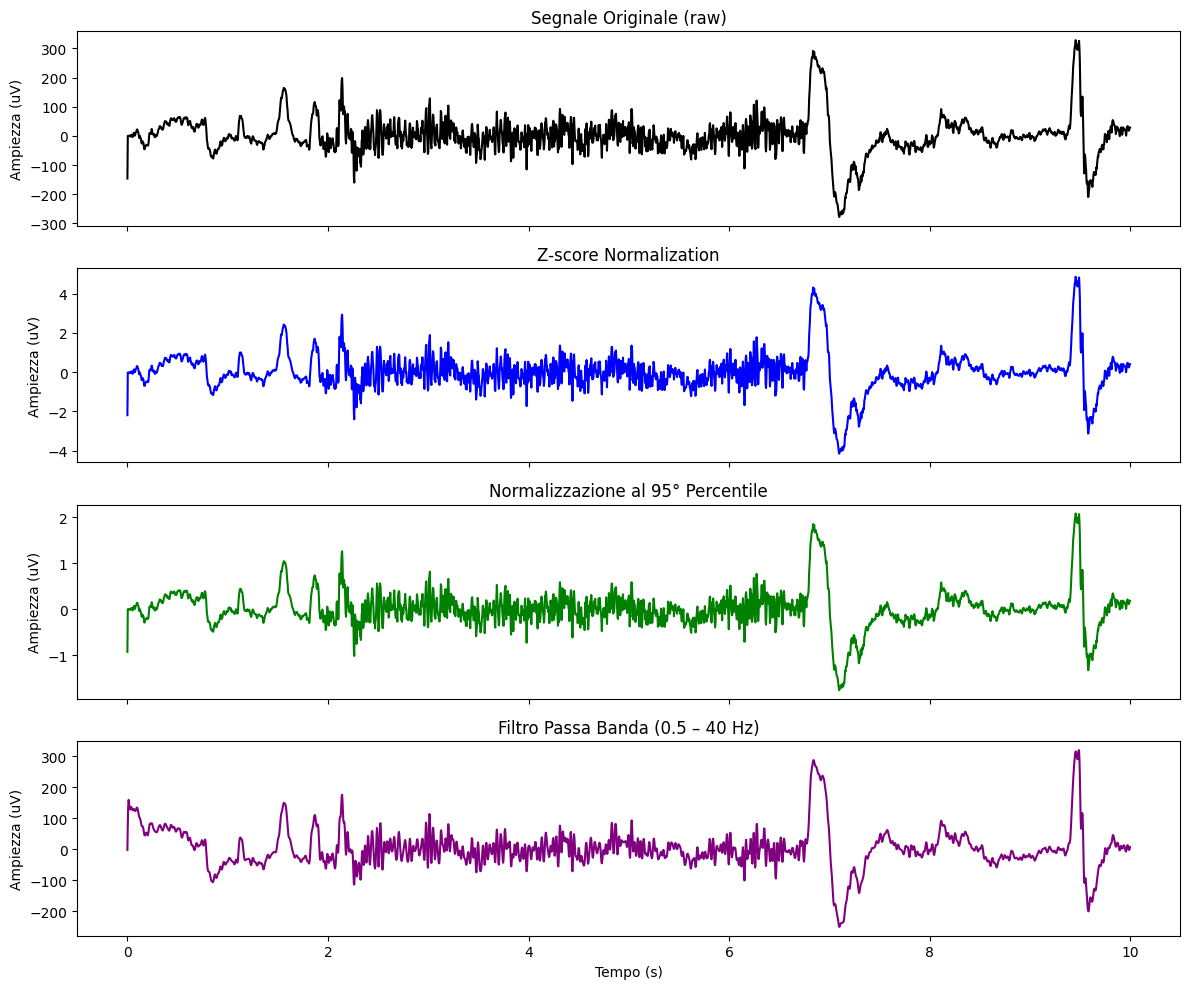

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# --- Funzioni di preprocessing ---

def z_score_normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def percentile_95_normalize(signal):
    p95 = np.percentile(np.abs(signal), 95)
    return signal / p95 if p95 != 0 else signal

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# --- Caricamento di un segmento di esempio ---
# Supponiamo: (channels, 2560), prendiamo il primo canale
segments = np.load("./CHB-MIT/processed_numpy/all_segments.npy")
sample = segments[0][0]  # primo segmento, primo canale

fs = 256  # frequenza di campionamento
t = np.arange(sample.shape[0]) / fs  # asse temporale in secondi

# --- Visualizzazione step-by-step ---
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1. Segnale originale
axs[0].plot(t, sample, color='black')
axs[0].set_title("Segnale Originale (raw)")

# 2. Z-score Normalization
zscored = z_score_normalize(sample)
axs[1].plot(t, zscored, color='blue')
axs[1].set_title("Z-score Normalization")

# 3. Normalizzazione al 95° percentile
percentiled = percentile_95_normalize(sample)
axs[2].plot(t, percentiled, color='green')
axs[2].set_title("Normalizzazione al 95° Percentile")

# 4. Filtro passa-banda (0.5 – 40 Hz)
filtered = bandpass_filter(sample, 0.5, 40, fs)
axs[3].plot(t, filtered, color='purple')
axs[3].set_title("Filtro Passa Banda (0.5 – 40 Hz)")

# --- Layout finale ---
for ax in axs:
    ax.set_ylabel("Ampiezza (uV)")
axs[-1].set_xlabel("Tempo (s)")
plt.tight_layout()
plt.show()

# Model BIOT Contrastive learning

In [5]:
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer

In [6]:
class PatchFrequencyEmbedding(nn.Module):
    def __init__(self, emb_size=256, n_freq=101):
        super().__init__()
        self.projection = nn.Linear(n_freq, emb_size)

    def forward(self, x):
        """
        x: (batch, freq, time)
        out: (batch, time, emb_size)
        """
        x = x.permute(0, 2, 1)
        x = self.projection(x)
        return x

In [7]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        self.clshead = nn.Sequential(
            nn.ELU(),
            nn.Linear(emb_size, n_classes),
        )

    def forward(self, x):
        out = self.clshead(x)
        return out

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Args:
            x: `embeddings`, shape (batch, max_len, d_model)
        Returns:
            `encoder input`, shape (batch, max_len, d_model)
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)

In [9]:
class BIOTEncoder(nn.Module):
    def __init__(
        self,
        emb_size=256,
        heads=8,
        depth=4,
        n_channels=16,
        n_fft=200,
        hop_length=100,
        **kwargs
    ):
        super().__init__()

        self.n_fft = n_fft
        self.hop_length = hop_length

        self.patch_embedding = PatchFrequencyEmbedding(
            emb_size=emb_size, n_freq=self.n_fft // 2 + 1
        )
        self.transformer = LinearAttentionTransformer(
            dim=emb_size,
            heads=heads,
            depth=depth,
            max_seq_len=1024,
            attn_layer_dropout=0.2,  # dropout right after self-attention layer
            attn_dropout=0.2,  # dropout post-attention
        )
        self.positional_encoding = PositionalEncoding(emb_size)

        # channel token, N_channels >= your actual channels
        self.channel_tokens = nn.Embedding(n_channels, 256)
        self.index = nn.Parameter(
            torch.LongTensor(range(n_channels)), requires_grad=False
        )

    def stft(self, sample):
        spectral = torch.stft( 
            input = sample.squeeze(1),
            n_fft = self.n_fft,
            hop_length = self.hop_length,
            center = False,
            onesided = True,
            return_complex = True,
        )
        return torch.abs(spectral)

    def forward(self, x, n_channel_offset=0, perturb=False):
        """
        x: [batch_size, channel, ts]
        output: [batch_size, emb_size]
        """
     
        emb_seq = []
        for i in range(x.shape[1]):
            channel_spec_emb = self.stft(x[:, i : i + 1, :])
            channel_spec_emb = self.patch_embedding(channel_spec_emb)
            batch_size, ts, _ = channel_spec_emb.shape
            # (batch_size, ts, emb)
            channel_token_emb = (
                self.channel_tokens(self.index[i + n_channel_offset])
                .unsqueeze(0)
                .unsqueeze(0)
                .repeat(batch_size, ts, 1)
            )
            # (batch_size, ts, emb)
            channel_emb = self.positional_encoding(channel_spec_emb + channel_token_emb)

            # perturb
            if perturb:
                ts = channel_emb.shape[1]
                ts_new = np.random.randint(ts // 2, ts)
                selected_ts = np.random.choice(range(ts), ts_new, replace=False)
                channel_emb = channel_emb[:, selected_ts]
            emb_seq.append(channel_emb)
        
        # (batch_size, 16 * ts, emb)
        emb = torch.cat(emb_seq, dim=1)
        # (batch_size, emb)
        emb = self.transformer(emb).mean(dim=1)
        return emb

In [10]:
# supervised classifier module
class BIOTClassifier(nn.Module):
    def __init__(self, emb_size=256, heads=8, depth=4, n_classes=6, **kwargs):
        super().__init__()
        self.biot = BIOTEncoder(emb_size=emb_size, heads=heads, depth=depth, **kwargs)
        self.classifier = ClassificationHead(emb_size, n_classes)

    def forward(self, x):
        x = self.biot(x)
        x = self.classifier(x)
        return x

In [11]:
# unsupervised pre-train module
class UnsupervisedPretrain(nn.Module):
    def __init__(self, emb_size=256, heads=8, depth=4, n_channels=18, **kwargs):
        super(UnsupervisedPretrain, self).__init__()
        self.biot = BIOTEncoder(emb_size, heads, depth, n_channels, **kwargs)
        self.prediction = nn.Sequential(
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, 256),
        )

    def forward(self, x, n_channel_offset=0):
        emb = self.biot(x, n_channel_offset, perturb=True)
        emb = self.prediction(emb)
        pred_emb = self.biot(x, n_channel_offset)
        return emb, pred_emb   

## Test

In [135]:
x = torch.randn(1, 16, 1000)
model = BIOTClassifier(n_fft=200, hop_length=200, depth=4, heads=8)
out = model(x)
print(out.shape)

model = UnsupervisedPretrain(n_fft=200, hop_length=200, depth=4, heads=8)
out1, out2 = model(x)
print(out1.shape, out2.shape)

emb_seq shape: (16, torch.Size([1, 5, 256]))
emb shape: torch.Size([1, 80, 256])
torch.Size([1, 6])
emb_seq shape: (16, torch.Size([1, 3, 256]))
emb shape: torch.Size([1, 51, 256])
emb_seq shape: (16, torch.Size([1, 5, 256]))
emb shape: torch.Size([1, 80, 256])
torch.Size([1, 256]) torch.Size([1, 256])


In [114]:
# Carica i segmenti dal file npy
segment_file_path = os.path.join(processed_root, "all_segments.npy")
try:
    all_segments_array = np.load(segment_file_path)
    print(f"Segmenti caricati con successo. Shape: {all_segments_array.shape}")

    # Seleziona un segmento da processare (ad esempio, il primo segmento)
    segment_signal = all_segments_array[0]  # (channels, segment_length)
    segment_tensor = torch.tensor(segment_signal, dtype=torch.float32).unsqueeze(0)  # (1, channels, segment_length)

    # Passa il segmento al modello
    out1, out2  = model(segment_tensor)
    print(out1.shape, out2.shape)  # (1, n_classes)
except Exception as e:
    print(f"Errore durante il caricamento o il processamento del segmento: {e}")

Segmenti caricati con successo. Shape: (4055, 23, 2560)
torch.Size([1, 256]) torch.Size([1, 256])


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
import numpy as np



### Dataset personalizzato ###
class NPYSampleDataset(Dataset):
    def __init__(self, npy_path):
        self.data = np.load(npy_path)  # shape: (N, C, T)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.tensor(x, dtype=torch.float32)


### LightningModule che usa UnsupervisedPretrain ###
class ContrastiveEvalModel(pl.LightningModule):
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature
        self.model = UnsupervisedPretrain(emb_size=256, heads=8, depth=4, n_channels=18)
        self.val_losses = []
    
    def validation_step(self, batch, batch_idx):
        # batch: [B, C, T]
        masked_emb, original_emb = self.model(batch)

        # Normalize embeddings
        masked_emb = F.normalize(masked_emb, dim=1)
        original_emb = F.normalize(original_emb, dim=1)

        logits = torch.mm(original_emb, masked_emb.T) / self.temperature
        labels = torch.arange(logits.size(0), device=self.device)

        loss = F.cross_entropy(logits, labels)
        self.val_losses.append(loss.item())  # Salva la perdita nella lista
        self.log("val_contrastive_loss", loss)
        return loss




Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation DataLoader 0: 100%|██████████| 127/127 [01:10<00:00,  1.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_contrastive_loss      3.4685797691345215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation DataLoader 0:   0%|          | 0/127 [01:47<?, ?it/s]


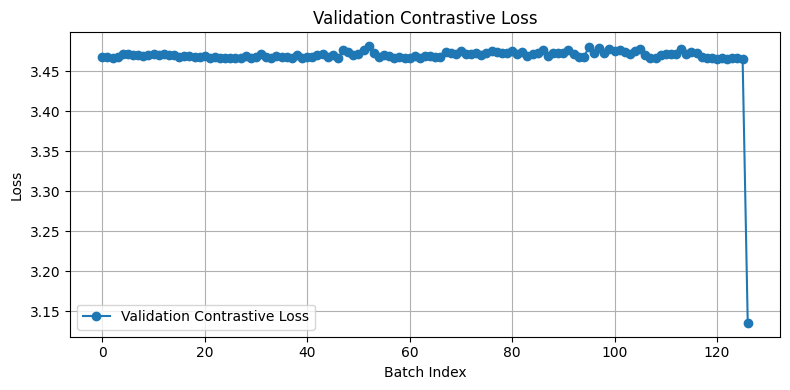

In [16]:
def main():
    # === CONFIGURAZIONI ===
    npy_path = "CHB-MIT/processed_numpy/all_segments.npy"  # <-- aggiorna con il tuo path
    ckpt_path = "pretrained-models/EEG-six-datasets-18-channels.ckpt"  # <-- checkpoint
    batch_size = 32

    # === Dataset + Loader ===
    dataset = NPYSampleDataset(npy_path)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # === Crea modello ===
    model = ContrastiveEvalModel()

    
    biot_classifier = BIOTClassifier(
        emb_size=256,
        heads=8,
        depth=4,
        n_classes=5,
        n_fft=200,
        hop_length=100,
        n_channels=18,  # here is 18
    )
    
    # === Carica i pesi (gestione robusta) ===
    #model.model.load_state_dict(torch.load(ckpt_path,  map_location="cpu"))
    biot_classifier.biot.load_state_dict(torch.load(ckpt_path))
    

    # === Trainer + Validazione ===
    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        max_epochs=1,
        logger=False,
    )
    trainer.validate(model, val_loader)

    # === Plot della loss ===
    plt.figure(figsize=(8, 4))
    plt.plot(model.val_losses, label="Validation Contrastive Loss", marker="o")
    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Validation Contrastive Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

In [191]:
print(model.state_dict().keys())

odict_keys(['biot.index', 'biot.patch_embedding.projection.weight', 'biot.patch_embedding.projection.bias', 'biot.transformer.layers.layers.0.0.fn.to_q.weight', 'biot.transformer.layers.layers.0.0.fn.to_k.weight', 'biot.transformer.layers.layers.0.0.fn.to_v.weight', 'biot.transformer.layers.layers.0.0.fn.to_out.weight', 'biot.transformer.layers.layers.0.0.fn.to_out.bias', 'biot.transformer.layers.layers.0.0.norm.weight', 'biot.transformer.layers.layers.0.0.norm.bias', 'biot.transformer.layers.layers.0.1.fn.fn.w1.weight', 'biot.transformer.layers.layers.0.1.fn.fn.w1.bias', 'biot.transformer.layers.layers.0.1.fn.fn.w2.weight', 'biot.transformer.layers.layers.0.1.fn.fn.w2.bias', 'biot.transformer.layers.layers.0.1.norm.weight', 'biot.transformer.layers.layers.0.1.norm.bias', 'biot.transformer.layers.layers.1.0.fn.to_q.weight', 'biot.transformer.layers.layers.1.0.fn.to_k.weight', 'biot.transformer.layers.layers.1.0.fn.to_v.weight', 'biot.transformer.layers.layers.1.0.fn.to_out.weight', 'bi